In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/jr0th/github/segmentation/code/')

import skimage.io
import skimage.morphology
import skimage.segmentation

import sklearn.metrics

import os.path
import os

import numpy as np

import time

debug = True

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

In [9]:
gt_data_dir = '/home/jr0th/github/segmentation/experiments/CP/segm_GT/'
mo_data_dir = '/home/jr0th/github/segmentation/experiments/CP/segm_CP/'

mat_dir = '/home/jr0th/github/segmentation/experiments/CP/IoU_CP/'

path_files_test = '/home/jr0th/github/segmentation/data/BBBC022/test.txt'

err_img_out_dir = '/home/jr0th/github/segmentation/experiments/CP/error_img/'

In [10]:
with open(path_files_test) as f:
    test_files = f.read().splitlines()

In [22]:
def visualize(mat, seg_gt, seg_model):

    # get number of nuclei
    nb_nuc_gt = mat.shape[0]
    nb_nuc_model = mat.shape[1]
    
    if debug:
        print('# nuclei ground truth', nb_nuc_gt)
        print('# nuclei model', nb_nuc_model)
    
    # only allow assignments if IoU is at least 0.5
    detection_map = (mat > 0.5)
    nb_matches = np.sum(detection_map)
    detection_map_gt = np.sum(detection_map, 1)
    detection_map_model = np.sum(detection_map, 0)
    
    # mask with matches
    detection_rate = mat * detection_map
    
    nb_overdetection = nb_nuc_model - nb_matches
    nb_underdetection = nb_nuc_gt - nb_matches
    
    if debug:
        print('# matches', nb_matches)
        print('# overdetections', nb_overdetection)
        print('# underdetections', nb_underdetection)
        
    mean_IoU = np.mean(np.sum(detection_rate, axis = 1))
    
    if debug:
        print('# mean IoU', mean_IoU)
    
    # plot masked matrix
    plt.figure(figsize=(10,10))
    plt.matshow(detection_rate)
    plt.show()
    
    # get indices of mislabeled cells
    error_underdetected = np.nonzero(detection_map_gt == 0)[0] + 1
    error_overdetected = np.nonzero(detection_map_model == 0)[0] + 1

    # get empty buffer image
    error_img = np.zeros((seg_model.shape[0], seg_model.shape[1], 3), dtype = np.ubyte)

    # color image
    brownish = [172, 128, 0]
    blueish = [31, 190, 214]
    for error in error_underdetected:
        # brownish: underdetected
        error_img[seg_gt == error, :] = brownish
    for error in error_overdetected:
        # blueish: overdetected
        error_img[seg_model == error, :] = error_img[seg_model == error, :] + blueish
        
    # pixels where under- and overdetection occured appear in pink
    
    return error_img

    

# nuclei ground truth 59
# nuclei model 50
# matches 50
# overdetections 0
# underdetections 9
# mean IoU 0.778389


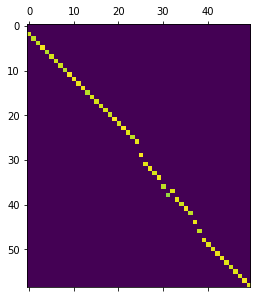

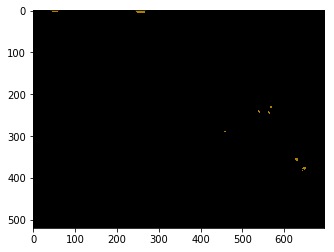

# nuclei ground truth 84
# nuclei model 75
# matches 73
# overdetections 2
# underdetections 11
# mean IoU 0.787522


/usr/local/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/jr0th/github/segmentation/experiments/CP/error_img/IXMtest_P21_s4_w19B7DC88B-10BB-4B51-9A10-9E30285688C1.png is a low contrast image
  warn('%s is a low contrast image' % fname)


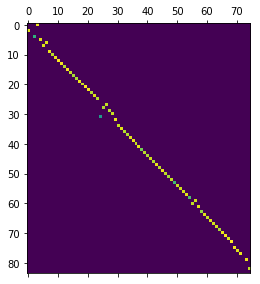

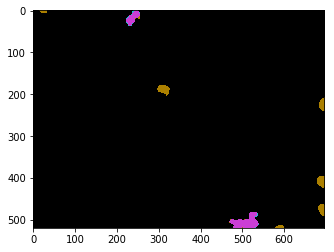

# nuclei ground truth 77
# nuclei model 72
# matches 71
# overdetections 1
# underdetections 6
# mean IoU 0.786871


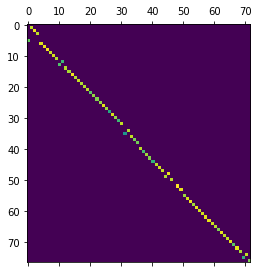

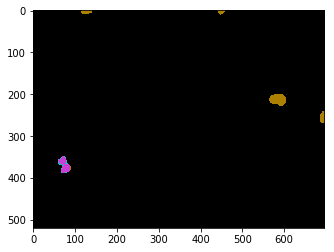

# nuclei ground truth 98
# nuclei model 80
# matches 73
# overdetections 7
# underdetections 25
# mean IoU 0.626691


/usr/local/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/jr0th/github/segmentation/experiments/CP/error_img/IXMtest_P15_s8_w1D26A5BC7-CF59-4027-B785-85AD33773609.png is a low contrast image
  warn('%s is a low contrast image' % fname)


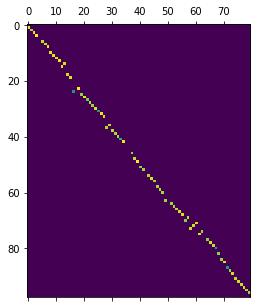

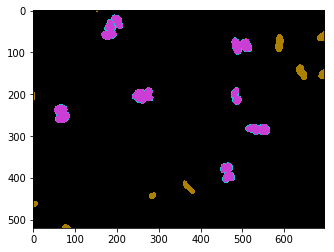

# nuclei ground truth 44
# nuclei model 43
# matches 43
# overdetections 0
# underdetections 1
# mean IoU 0.867381


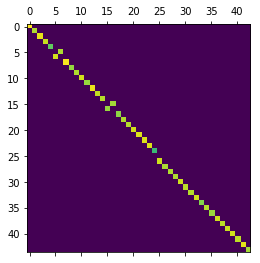

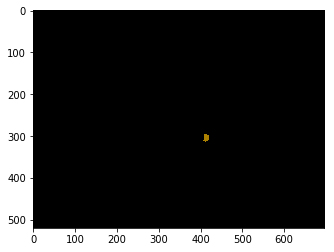

# nuclei ground truth 88
# nuclei model 82
# matches 81
# overdetections 1
# underdetections 7
# mean IoU 0.831115


/usr/local/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/jr0th/github/segmentation/experiments/CP/error_img/IXMtest_P07_s8_w19D682C29-5685-4A33-8CAA-F0797DD7F021.png is a low contrast image
  warn('%s is a low contrast image' % fname)


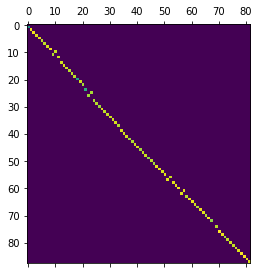

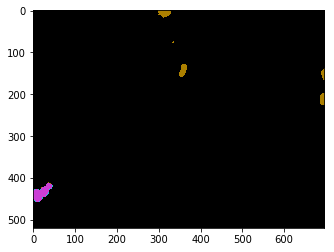

# nuclei ground truth 74
# nuclei model 64
# matches 64
# overdetections 0
# underdetections 10
# mean IoU 0.757544


/usr/local/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/jr0th/github/segmentation/experiments/CP/error_img/IXMtest_O04_s2_w19A18B0D8-8E8B-4572-A5C0-5C678F3AD54C.png is a low contrast image
  warn('%s is a low contrast image' % fname)


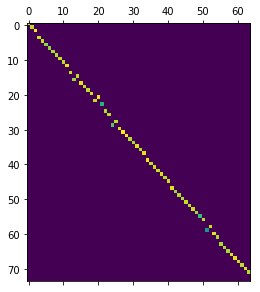

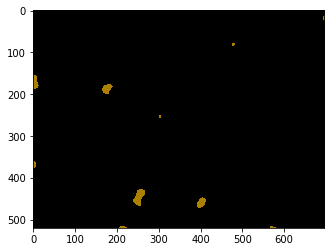

# nuclei ground truth 78
# nuclei model 67
# matches 66
# overdetections 1
# underdetections 12
# mean IoU 0.766334


/usr/local/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/jr0th/github/segmentation/experiments/CP/error_img/IXMtest_O02_s4_w1814603DA-DD56-44EF-98C5-AFF3B636F986.png is a low contrast image
  warn('%s is a low contrast image' % fname)


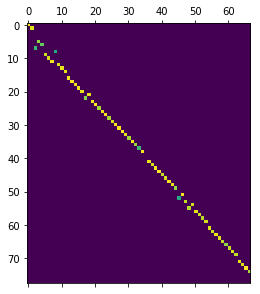

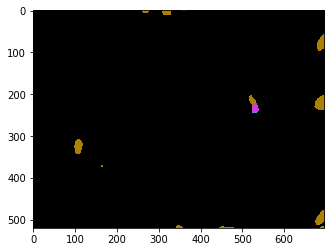

# nuclei ground truth 26
# nuclei model 24
# matches 23
# overdetections 1
# underdetections 3
# mean IoU 0.679589


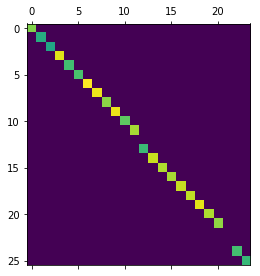

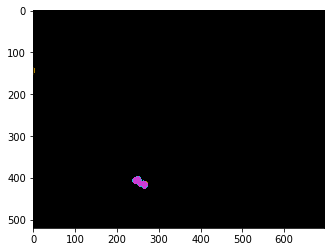

# nuclei ground truth 144
# nuclei model 126
# matches 119
# overdetections 7
# underdetections 25
# mean IoU 0.711808


/usr/local/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/jr0th/github/segmentation/experiments/CP/error_img/IXMtest_N21_s1_w14F264B20-62D6-47EC-9BCD-B9416AB302D9.png is a low contrast image
  warn('%s is a low contrast image' % fname)


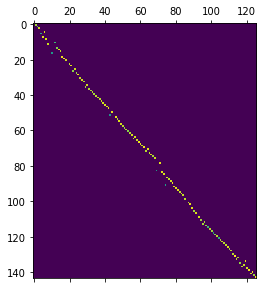

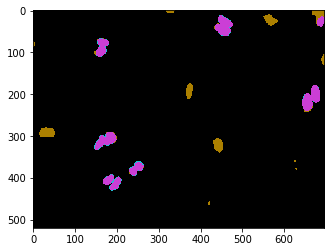

# nuclei ground truth 87
# nuclei model 79
# matches 75
# overdetections 4
# underdetections 12
# mean IoU 0.770746


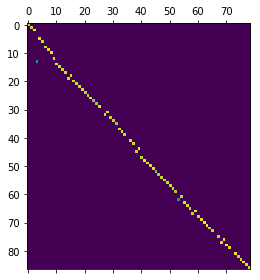

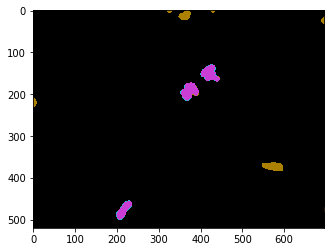

# nuclei ground truth 119
# nuclei model 103
# matches 98
# overdetections 5
# underdetections 21
# mean IoU 0.7411


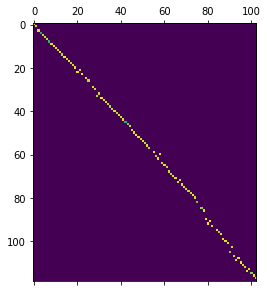

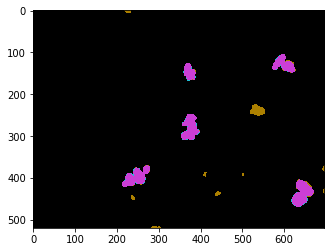

# nuclei ground truth 159
# nuclei model 134
# matches 127
# overdetections 7
# underdetections 32
# mean IoU 0.724988


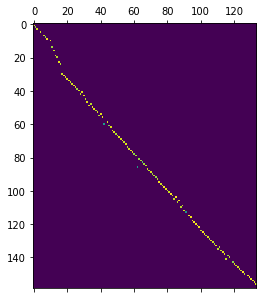

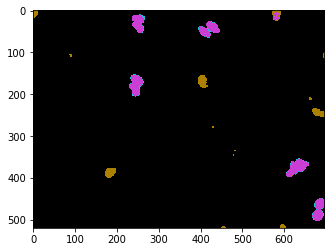

# nuclei ground truth 188
# nuclei model 151
# matches 134
# overdetections 17
# underdetections 54
# mean IoU 0.63248


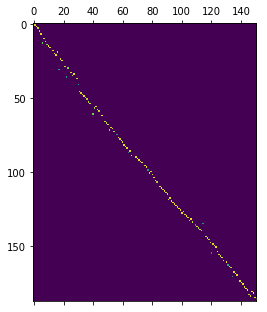

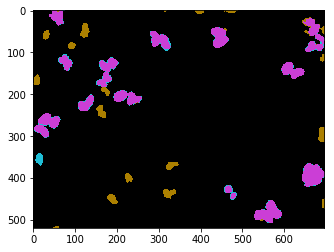

# nuclei ground truth 189
# nuclei model 149
# matches 142
# overdetections 7
# underdetections 47
# mean IoU 0.645511


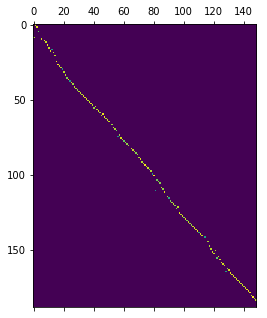

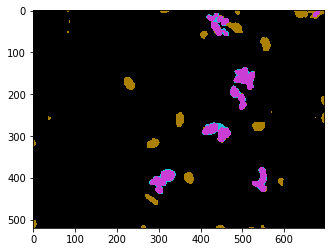

# nuclei ground truth 145
# nuclei model 131
# matches 130
# overdetections 1
# underdetections 15
# mean IoU 0.784354


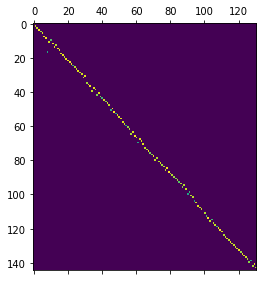

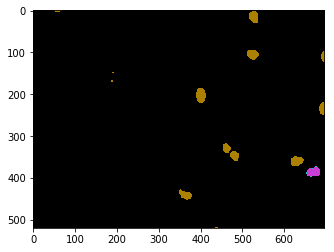

# nuclei ground truth 134
# nuclei model 116
# matches 111
# overdetections 5
# underdetections 23
# mean IoU 0.731359


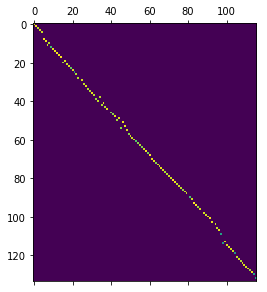

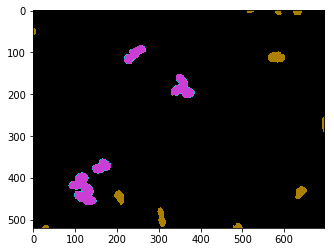

FileNotFoundError: [Errno 2] No such file or directory: '/home/jr0th/github/segmentation/experiments/CP/segm_GT/IXMtest_K03_s5_w1DC4CE558-042C-482E-8CAE-FCCB57AA9A55.png'

In [26]:
for filename in test_files:
    
    filename_wo_ext = os.path.splitext(filename)[0]
    
    # load error matrices
    IoU = np.load(mat_dir + filename_wo_ext + '.npy')

    # load segmentations
    seg_gt = skimage.io.imread(gt_data_dir + filename)
    seg_mo = skimage.io.imread(mo_data_dir + filename)
    
    # visualize only if matrices are full (no empty images and some detection)
    if(IoU.size != 0):
        error_img = visualize(IoU, seg_gt, seg_mo)
        plt.imshow(error_img)
        plt.show()
        skimage.io.imsave(err_img_out_dir + filename, error_img)
        